In [15]:
from random import sample
from tqdm.notebook import tqdm
from collections import deque

import gym
from gym import spaces
from gym.utils import seeding

import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (8,4)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

In [6]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [7]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [ ]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=10, fontx=10):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=10, fontx=30):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [ ]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=10, fontx=10):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

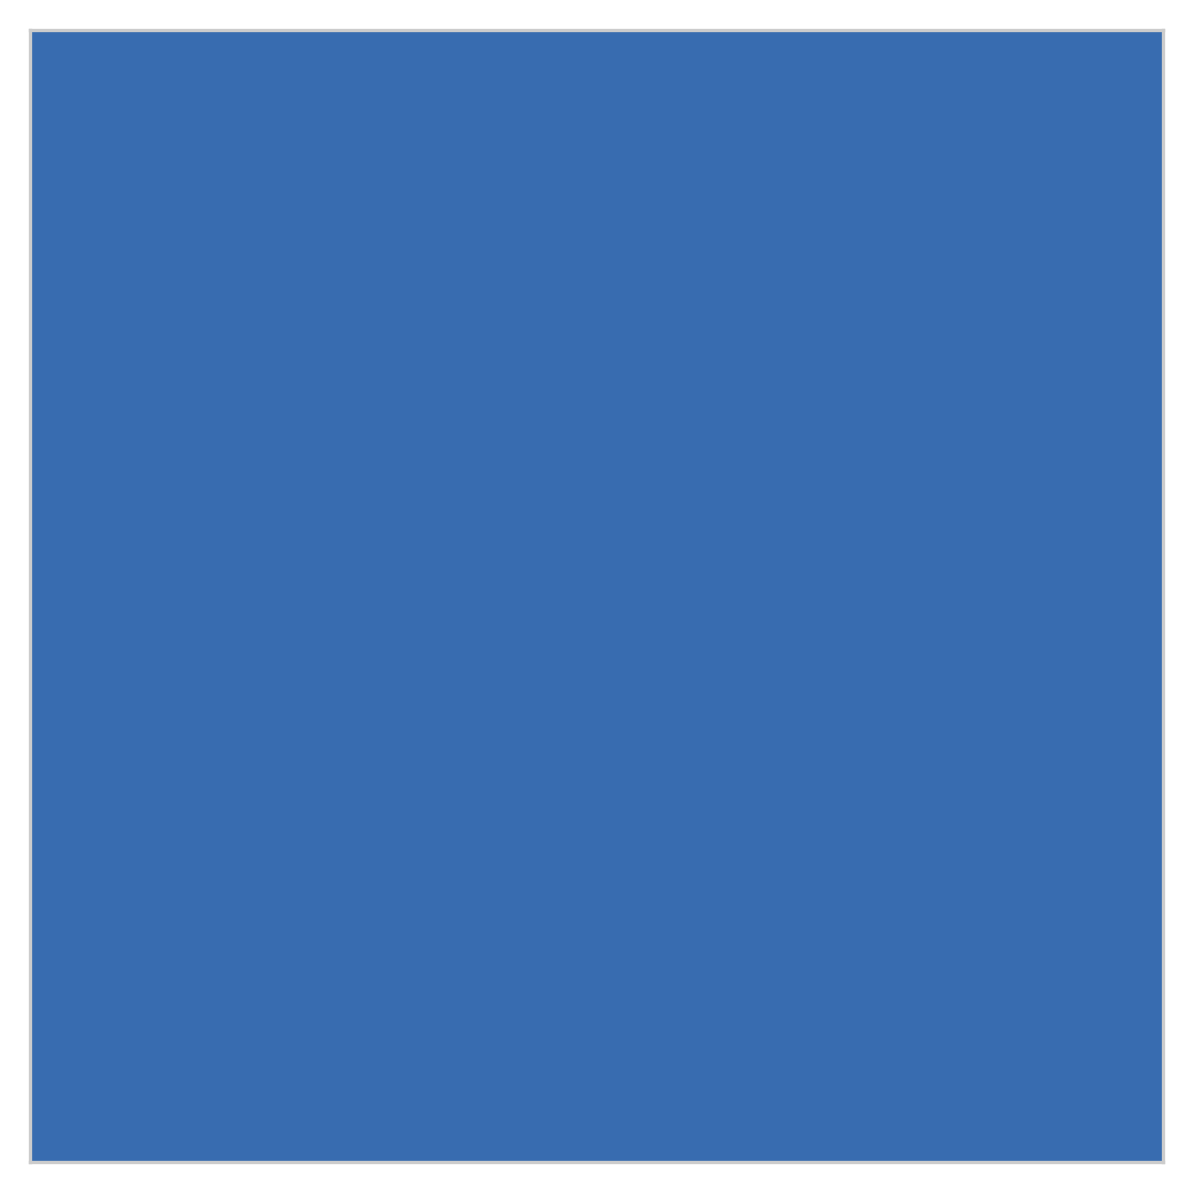

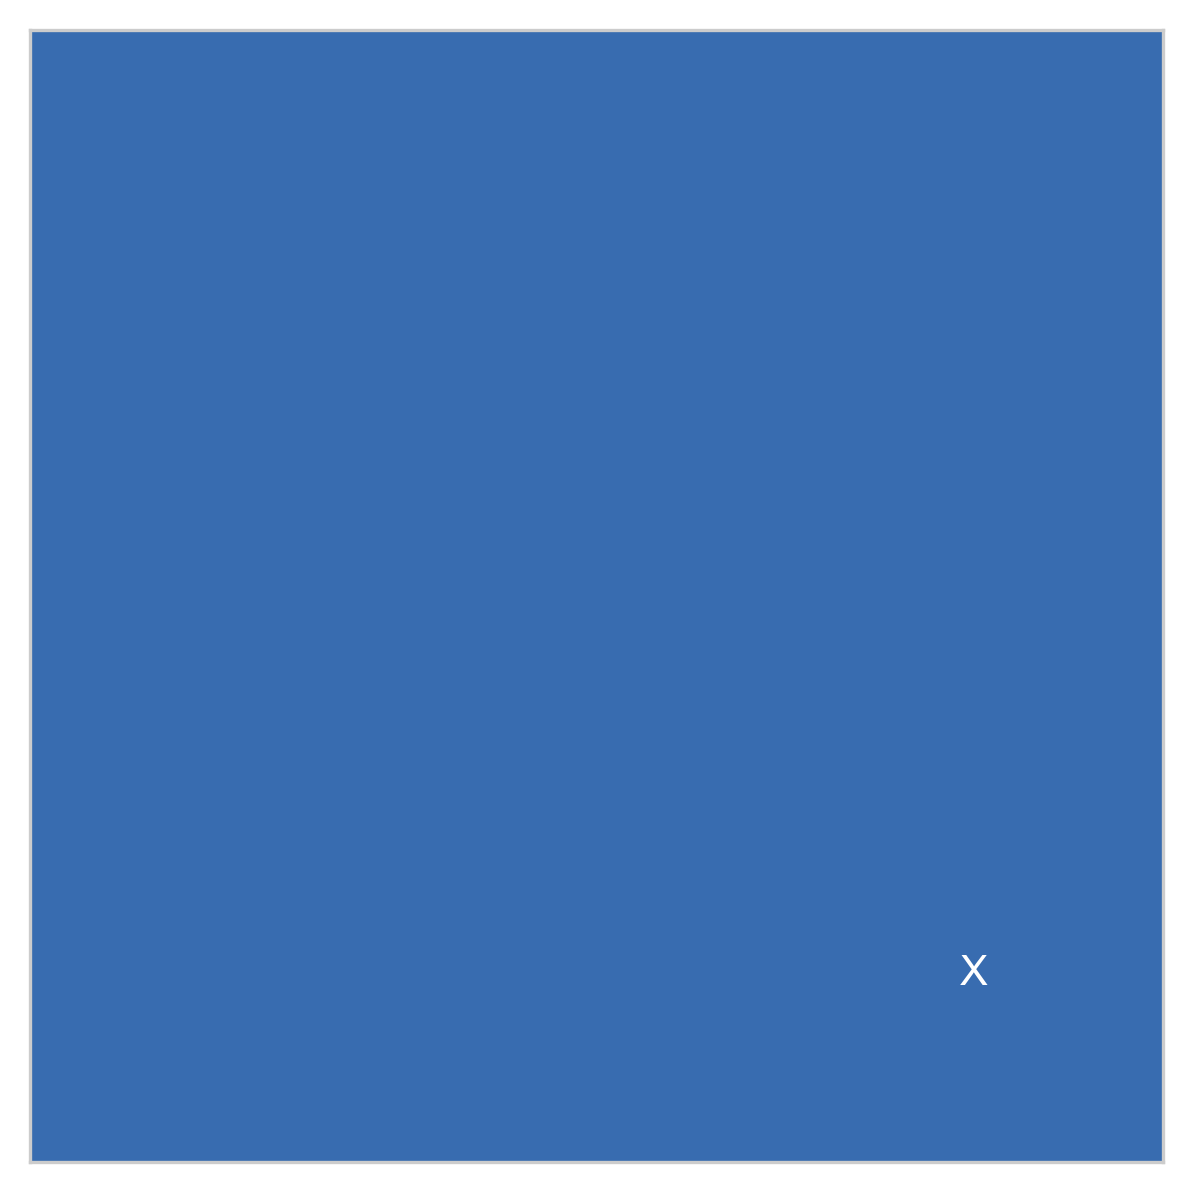

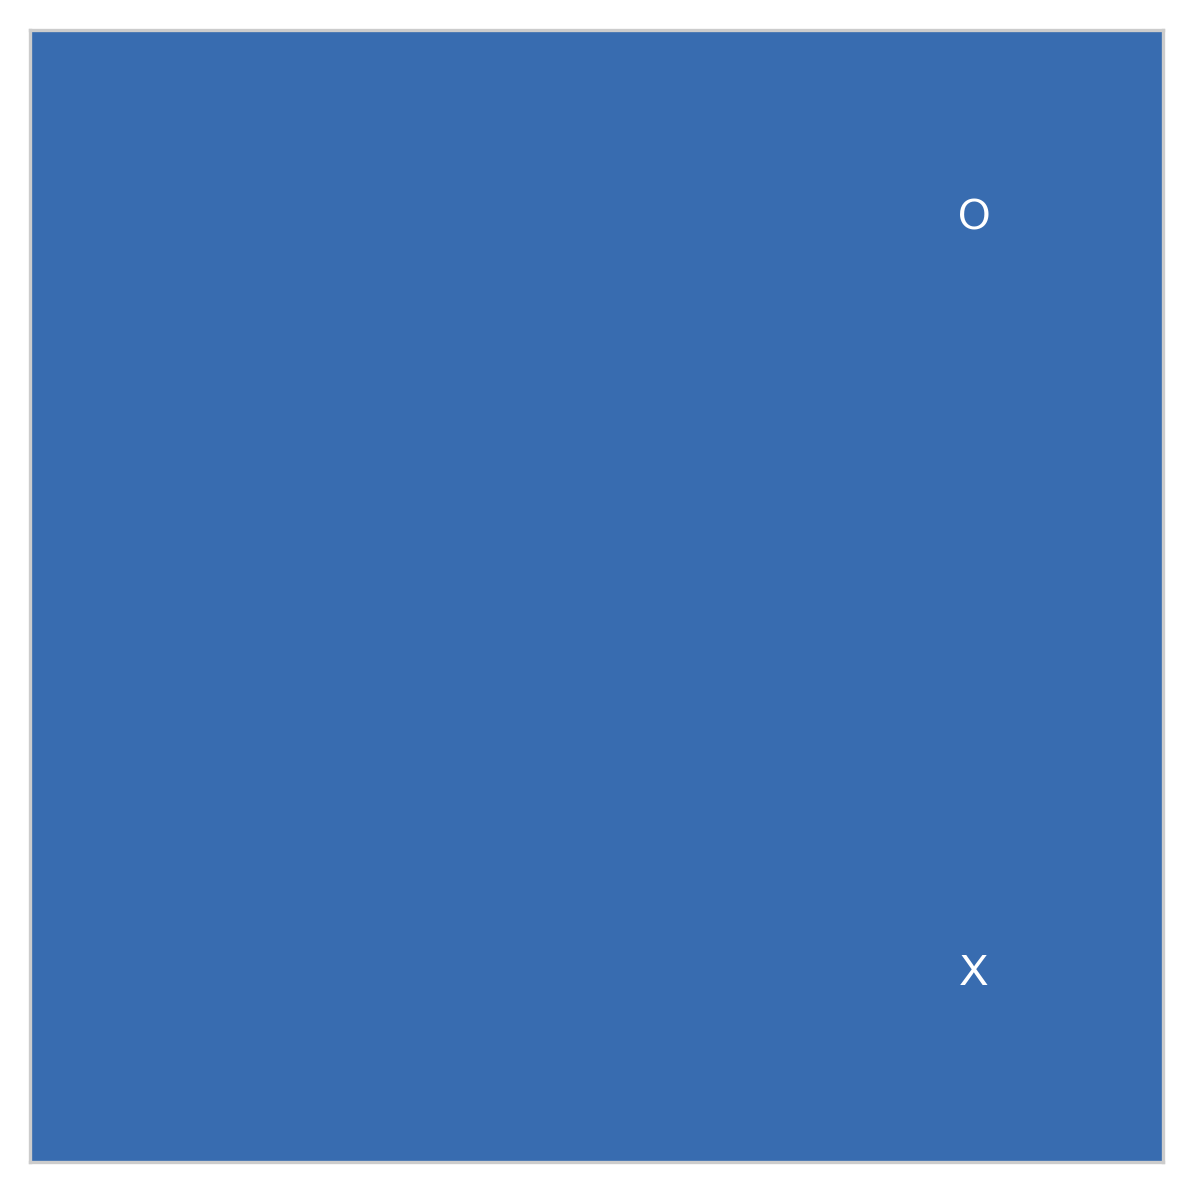

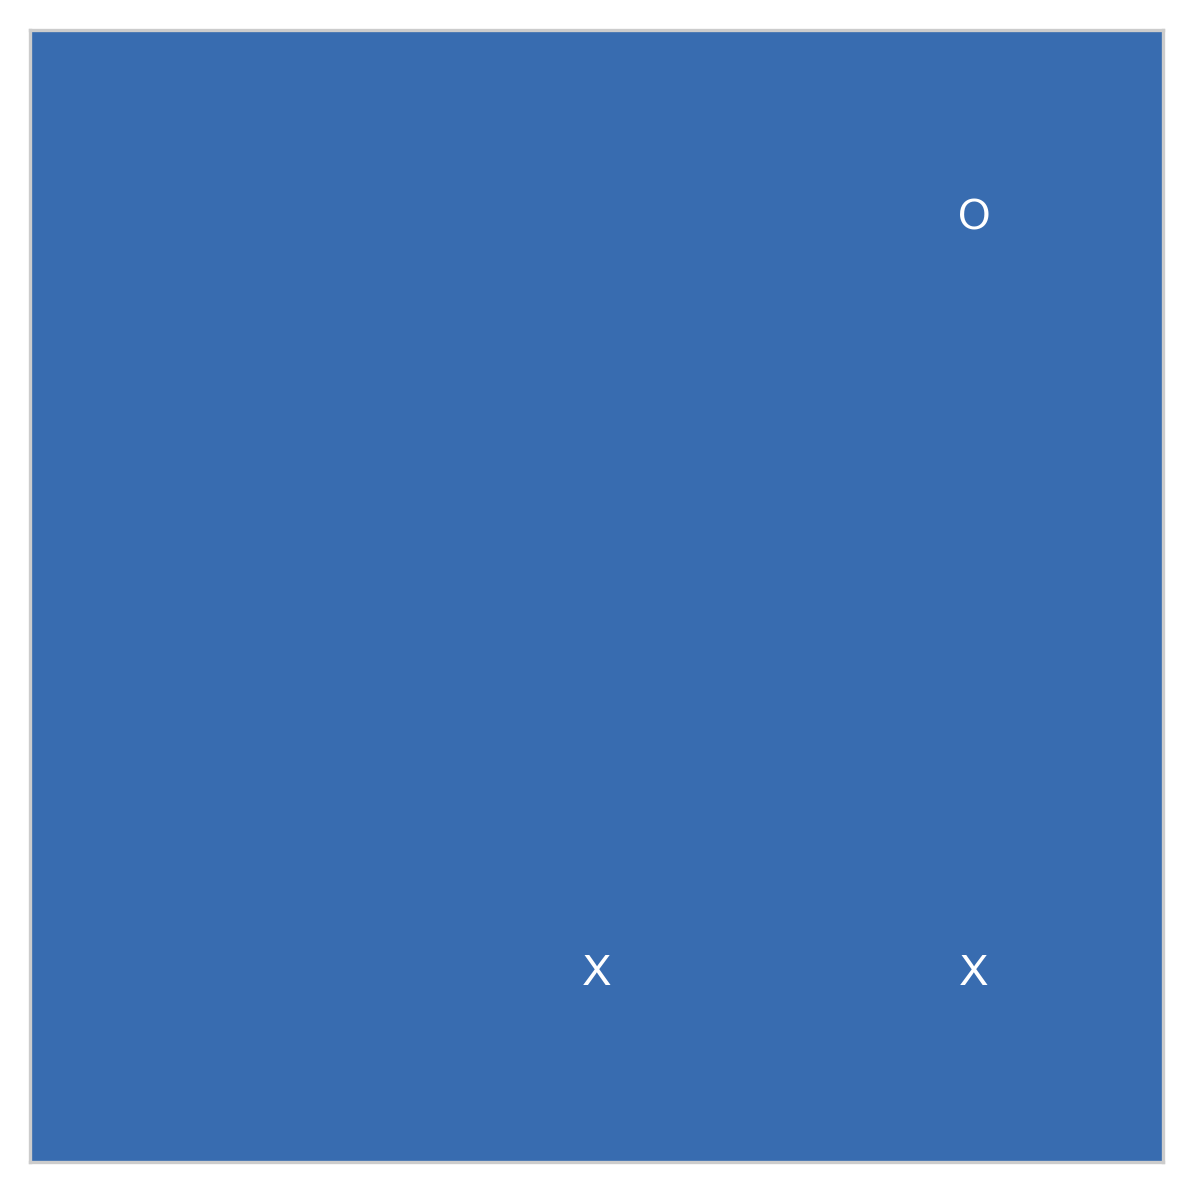

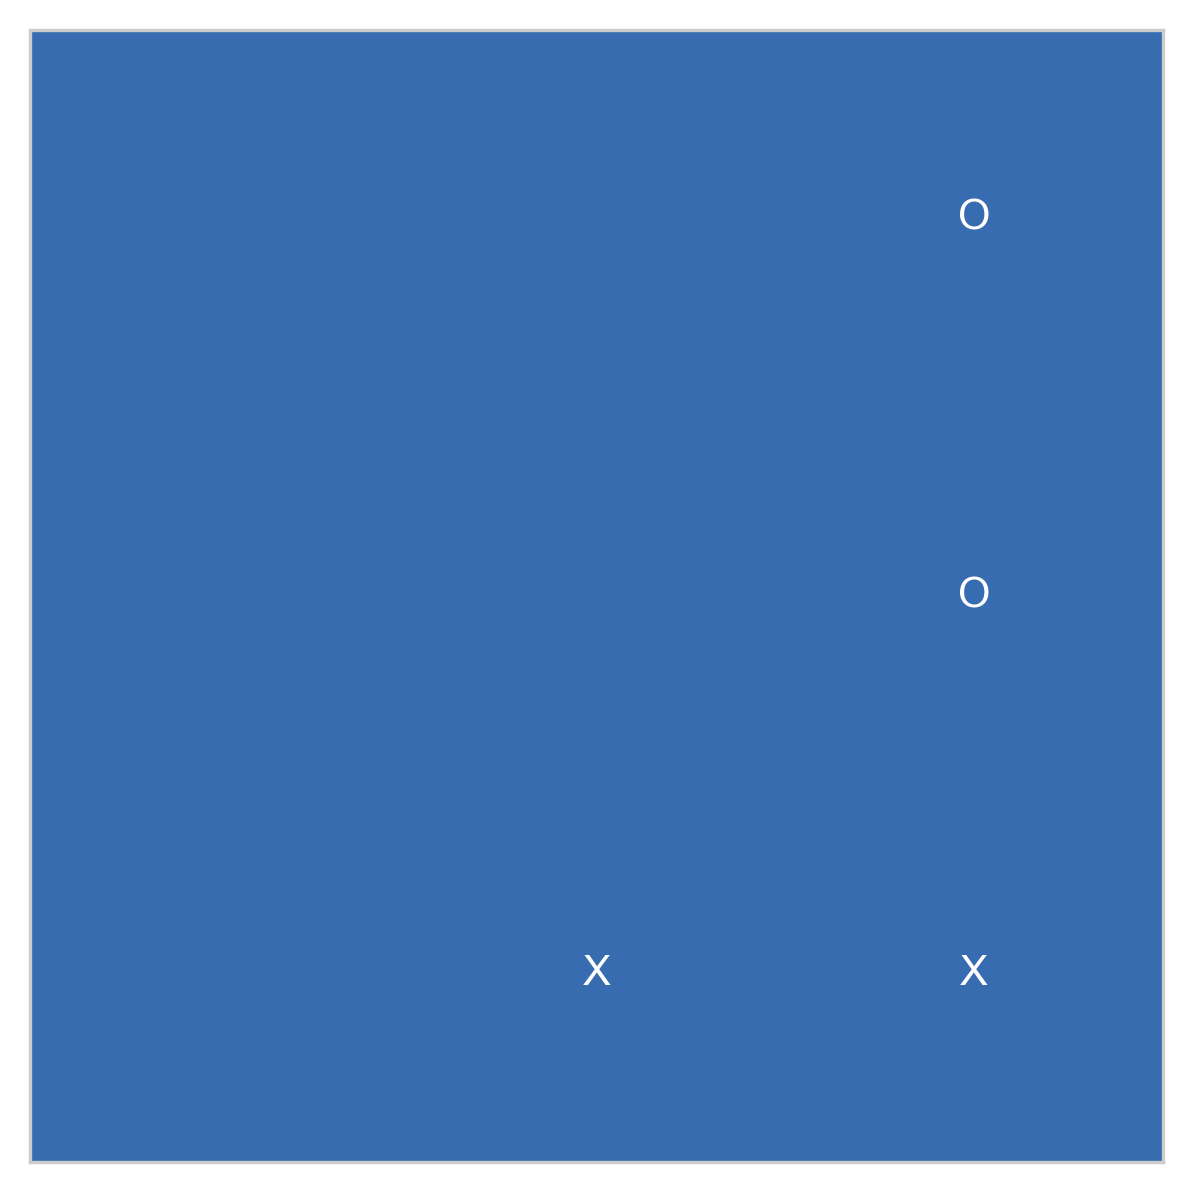

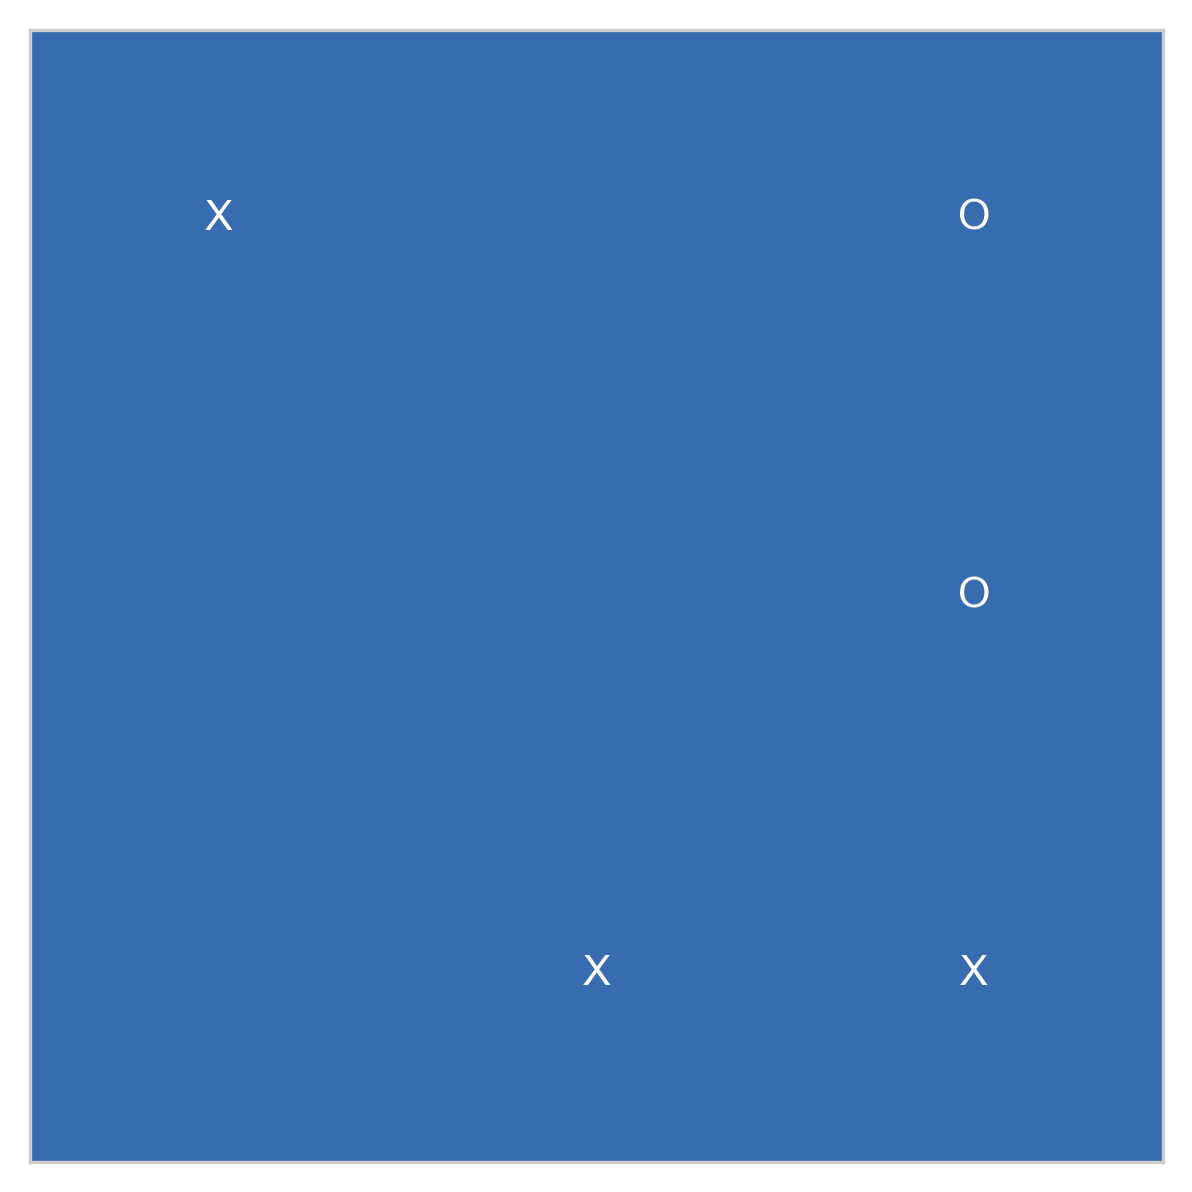

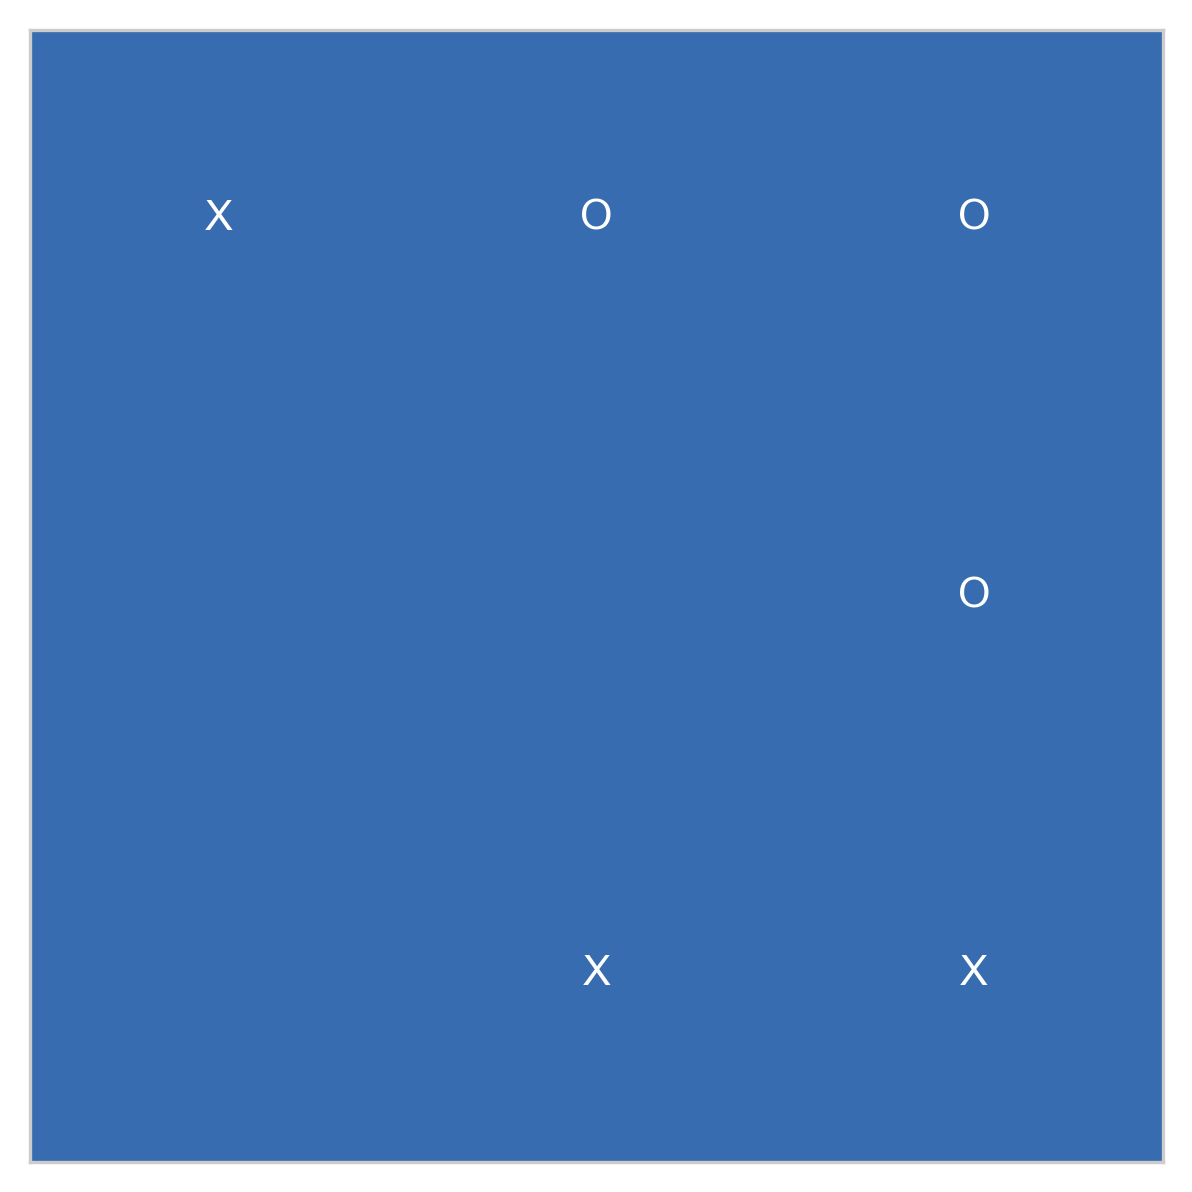

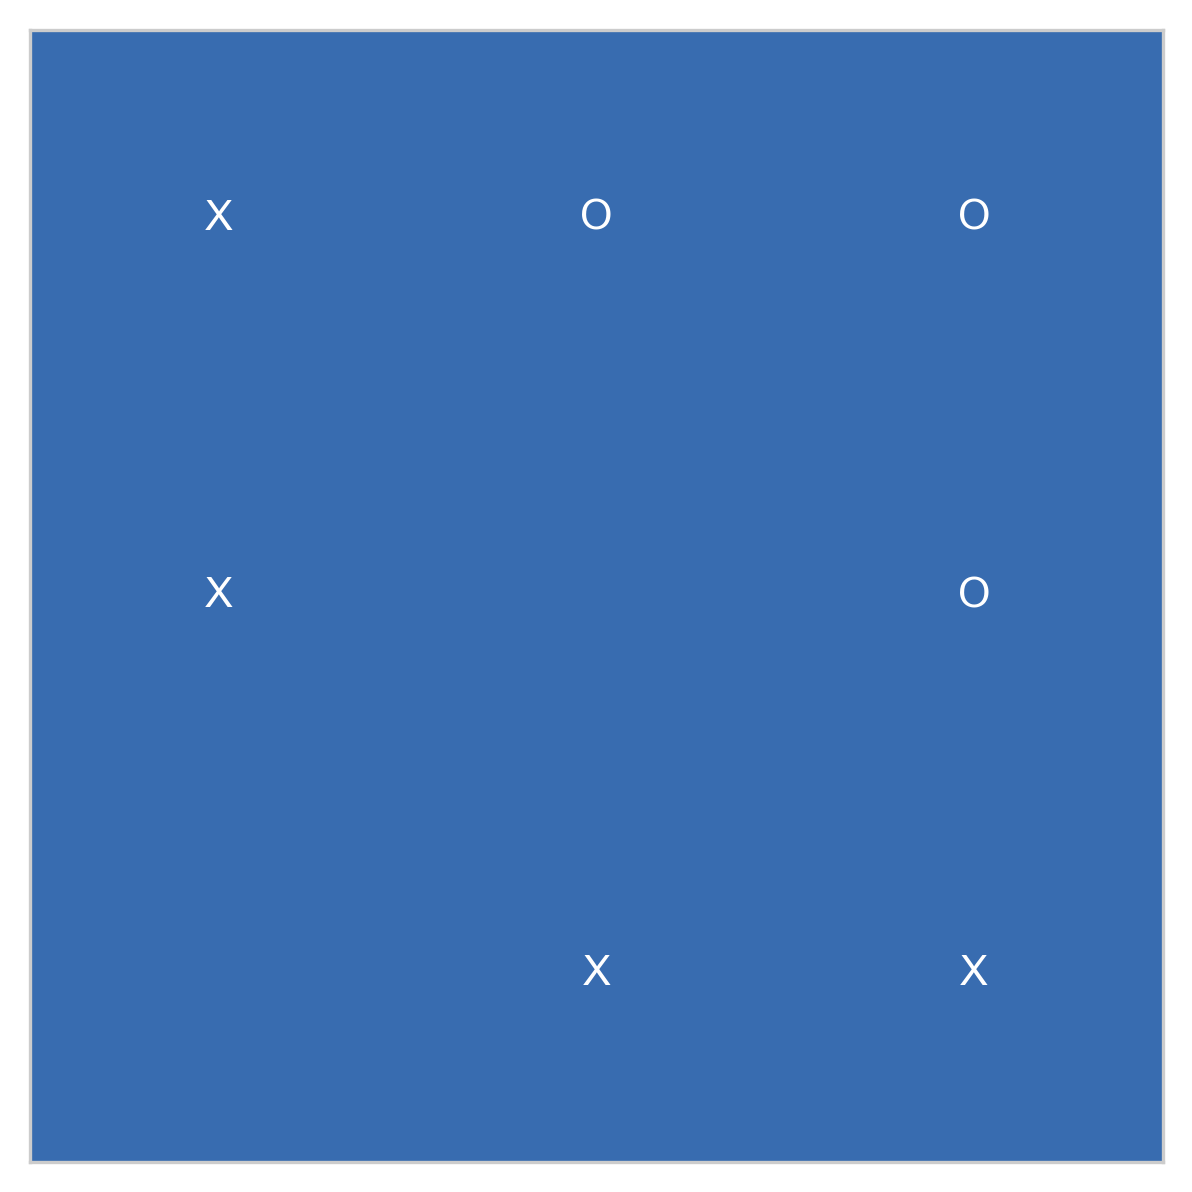

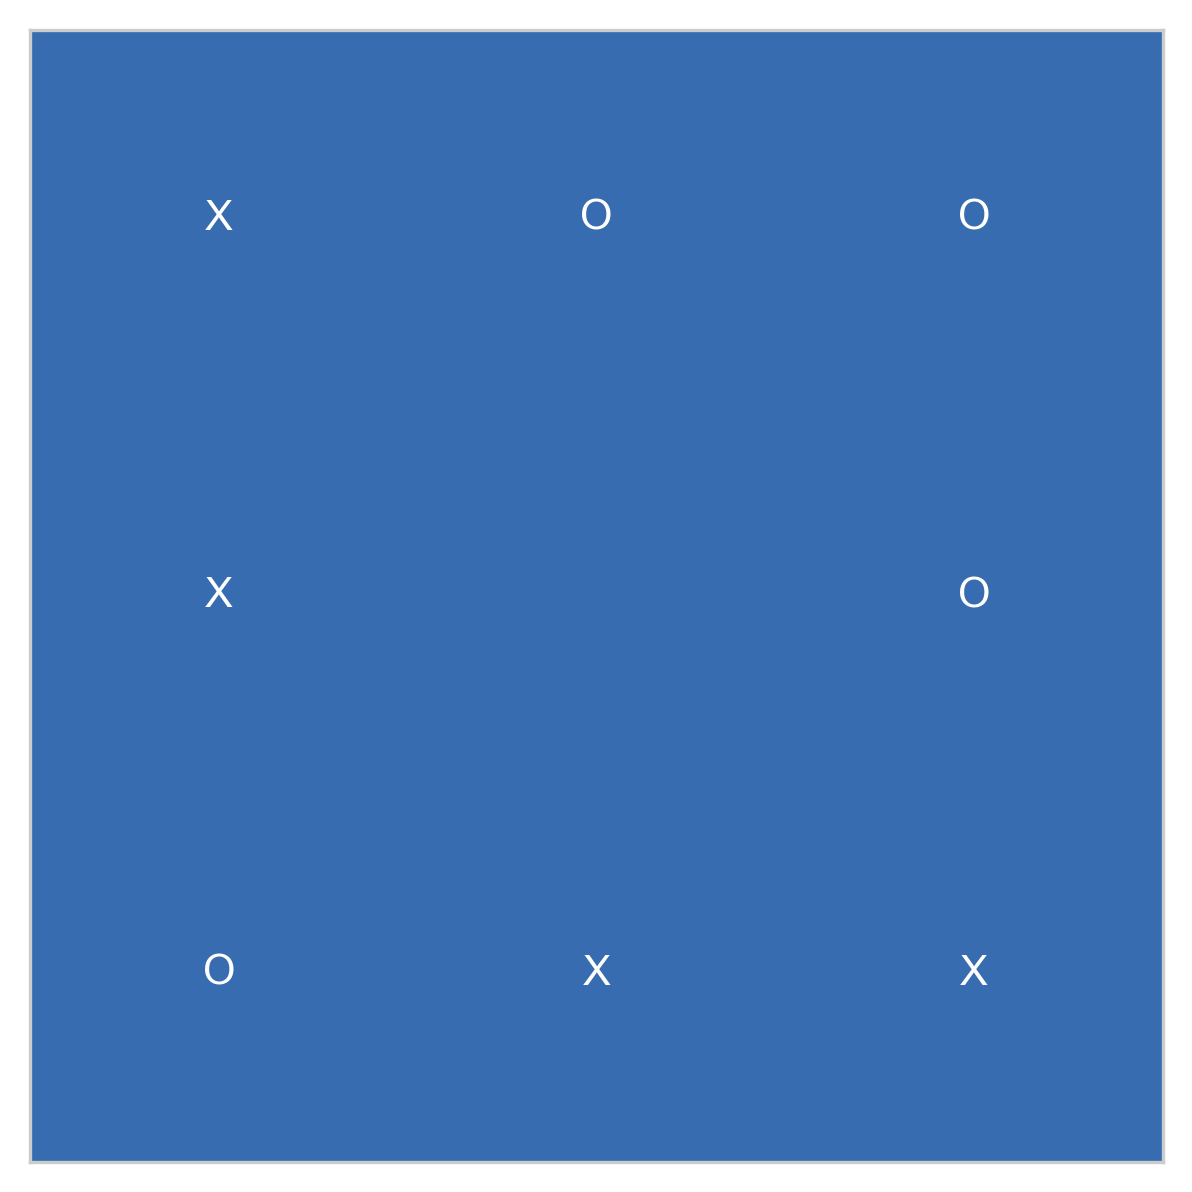

In [ ]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=4)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=10)

In [ ]:
# Функция инициализации Q-function
def get_random_Q(nS, nA, final_states):
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0
    return Q

# Функция взятия политики по Q-function
def compute_policy_by_Q(Q):
    return np.argmax(Q, axis=1)

### Часть 1. Вопрос 1

In [ ]:
env = TicTacToe(3, 3, 3)

In [4]:
from itertools import product

In [ ]:
# generate states space: all the states where -1 < (number of naughts - number of crosses) < 1

combinations = product('012', repeat=9)

valid_states = []
infinum = 0.8
supremum = 1.2

for s in combinations:
    criterium = sum([int(n) for n in s]) / 9
    if infinum < criterium < supremum:
        valid_states.append(''.join(s))
        
states = {h: v for v, h in enumerate(valid_states)}

In [ ]:
nS = len(valid_states)
nA = 9

In [5]:
# actions dict:
action_space = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]], dtype='int64')

def action_to_num(action):
    return N_ROWS * action[0] + action[1]

In [6]:
# Dictionary mapping ints to actions. Similar to env.action_from_int
action_space_dict = {num: action for num, action in enumerate(action_space.tolist())}

In [7]:
# Function mimicking reward obtained through playing against random policy

def episode_reward(pi, player=1):
    env.reset()
    done = False
    observation = ['111111111']

    while not done:
        empty_cells = env.getEmptySpaces().tolist()
        
        if env.curTurn == player:
            
            s = states[observation[0]]
            next_action = action_space_dict[pi[s]]
            
            if next_action in empty_cells:
                observation, reward, done, info = env.step(next_action)
            else:
                next_action = empty_cells[np.random.randint(len(empty_cells))]
                observation, reward, done, info = env.step(next_action)
        else:
            next_action = empty_cells[np.random.randint(len(empty_cells))]
            observation, reward, done, info = env.step(next_action)
    
    return reward

In [8]:
# Player class containing both policy and Q-function along with move() and update() methods
# Naughts and crosses are assumed to be of Player class

class Player():
    def __init__(self, name, pi, Q, epsilon=0.1, gamma=1., alpha=0.01):
        self.name = name
        self.pi = pi
        self.Q = Q
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.s = states['111111111']
        self.a = None
        
    def move(self, env, start=None):
        if start is not None:
            self.a = np.random.randint(nA)
        else:
            state, vacant_cells, cur_turn = env.getState()
            self.s = states[state]
            actions = vacant_cells.tolist()
            
            if (action_space_dict[self.pi[self.s]] in actions) and (len(actions) > 1):
                actions.remove(action_space_dict[self.pi[self.s]])
                action = action_space_dict[self.pi[self.s]] if np.random.rand() > self.epsilon else sample(actions, 1)[0]
            else:
                action = sample(actions, 1)[0]

            self.a = env.int_from_action(action)
            
        observation, reward, done, _ = env.step(env.action_from_int(self.a))
        
        if done:
            self.Q[self.s, self.a] = reward
            
            if self.name == 'crosses':
                self.pi = np.argmax(self.Q, axis=1)
            else:
                self.pi = np.argmin(self.Q, axis=1)

        return observation, reward, done
        
    def update(self, env, reward):
        
        s = self.s
        a = self.a
        
        new_state, _, _ = env.getState()
        s_prime = states[new_state]

        if reward != 0:
            self.Q[s, a] = reward
        else:
            if self.name == 'crosses':
                self.Q[s][a] = self.Q[s][a] + self.alpha * (self.gamma * np.max(self.Q[s_prime]) - self.Q[s][a])
                self.pi = np.argmax(self.Q, axis=1)
            else:
                self.Q[s][a] = self.Q[s][a] + self.alpha * (self.gamma * np.min(self.Q[s_prime]) - self.Q[s][a])
                self.pi = np.argmin(self.Q, axis=1)
                
        self.s = s_prime

In [ ]:
# Training loop

Q_c = np.zeros((nS, nA))
pi_c = np.argmax(Q_c, axis=1)
crosses = Player('crosses', pi_c, Q_c, epsilon=0.45, alpha=0.05)
crosses_policies = []

Q_n = np.zeros((nS, nA))
pi_n = np.argmax(Q_n, axis=1)
naughts = Player('naughts', pi_n, Q_n, epsilon=0.45, alpha=0.05)
naughts_policies = []

total_episodes = 30001

for i in range(total_episodes):
    env.reset()
    crosses.move(env, 1)
    done = False

    while not done:
        new_state, reward, done = naughts.move(env)
        crosses.update(env, reward)
        if done:
            break
            
        new_state, reward, done = crosses.move(env)
        naughts.update(env, reward)
        if done:
            break
            
    if (i > 0) and (i % 5000 == 0):
        crosses_policies.append(crosses.pi)
        naughts_policies.append(naughts.pi)

In [ ]:
crosses_results = []
naughts_results = []


n = 5000

for policy in crosses_policies:
    res = 0
    
    for i in range(n):
        
        reward = episode_reward(policy, player=1)
        if reward == 1:
            res += 1

    crosses_results.append(res / n)
        
for policy in naughts_policies:
    res = 0
    
    for i in range(n):
        reward = episode_reward(policy, player=-1)
        if reward == -1:
            res += 1

    naughts_results.append(res / n)

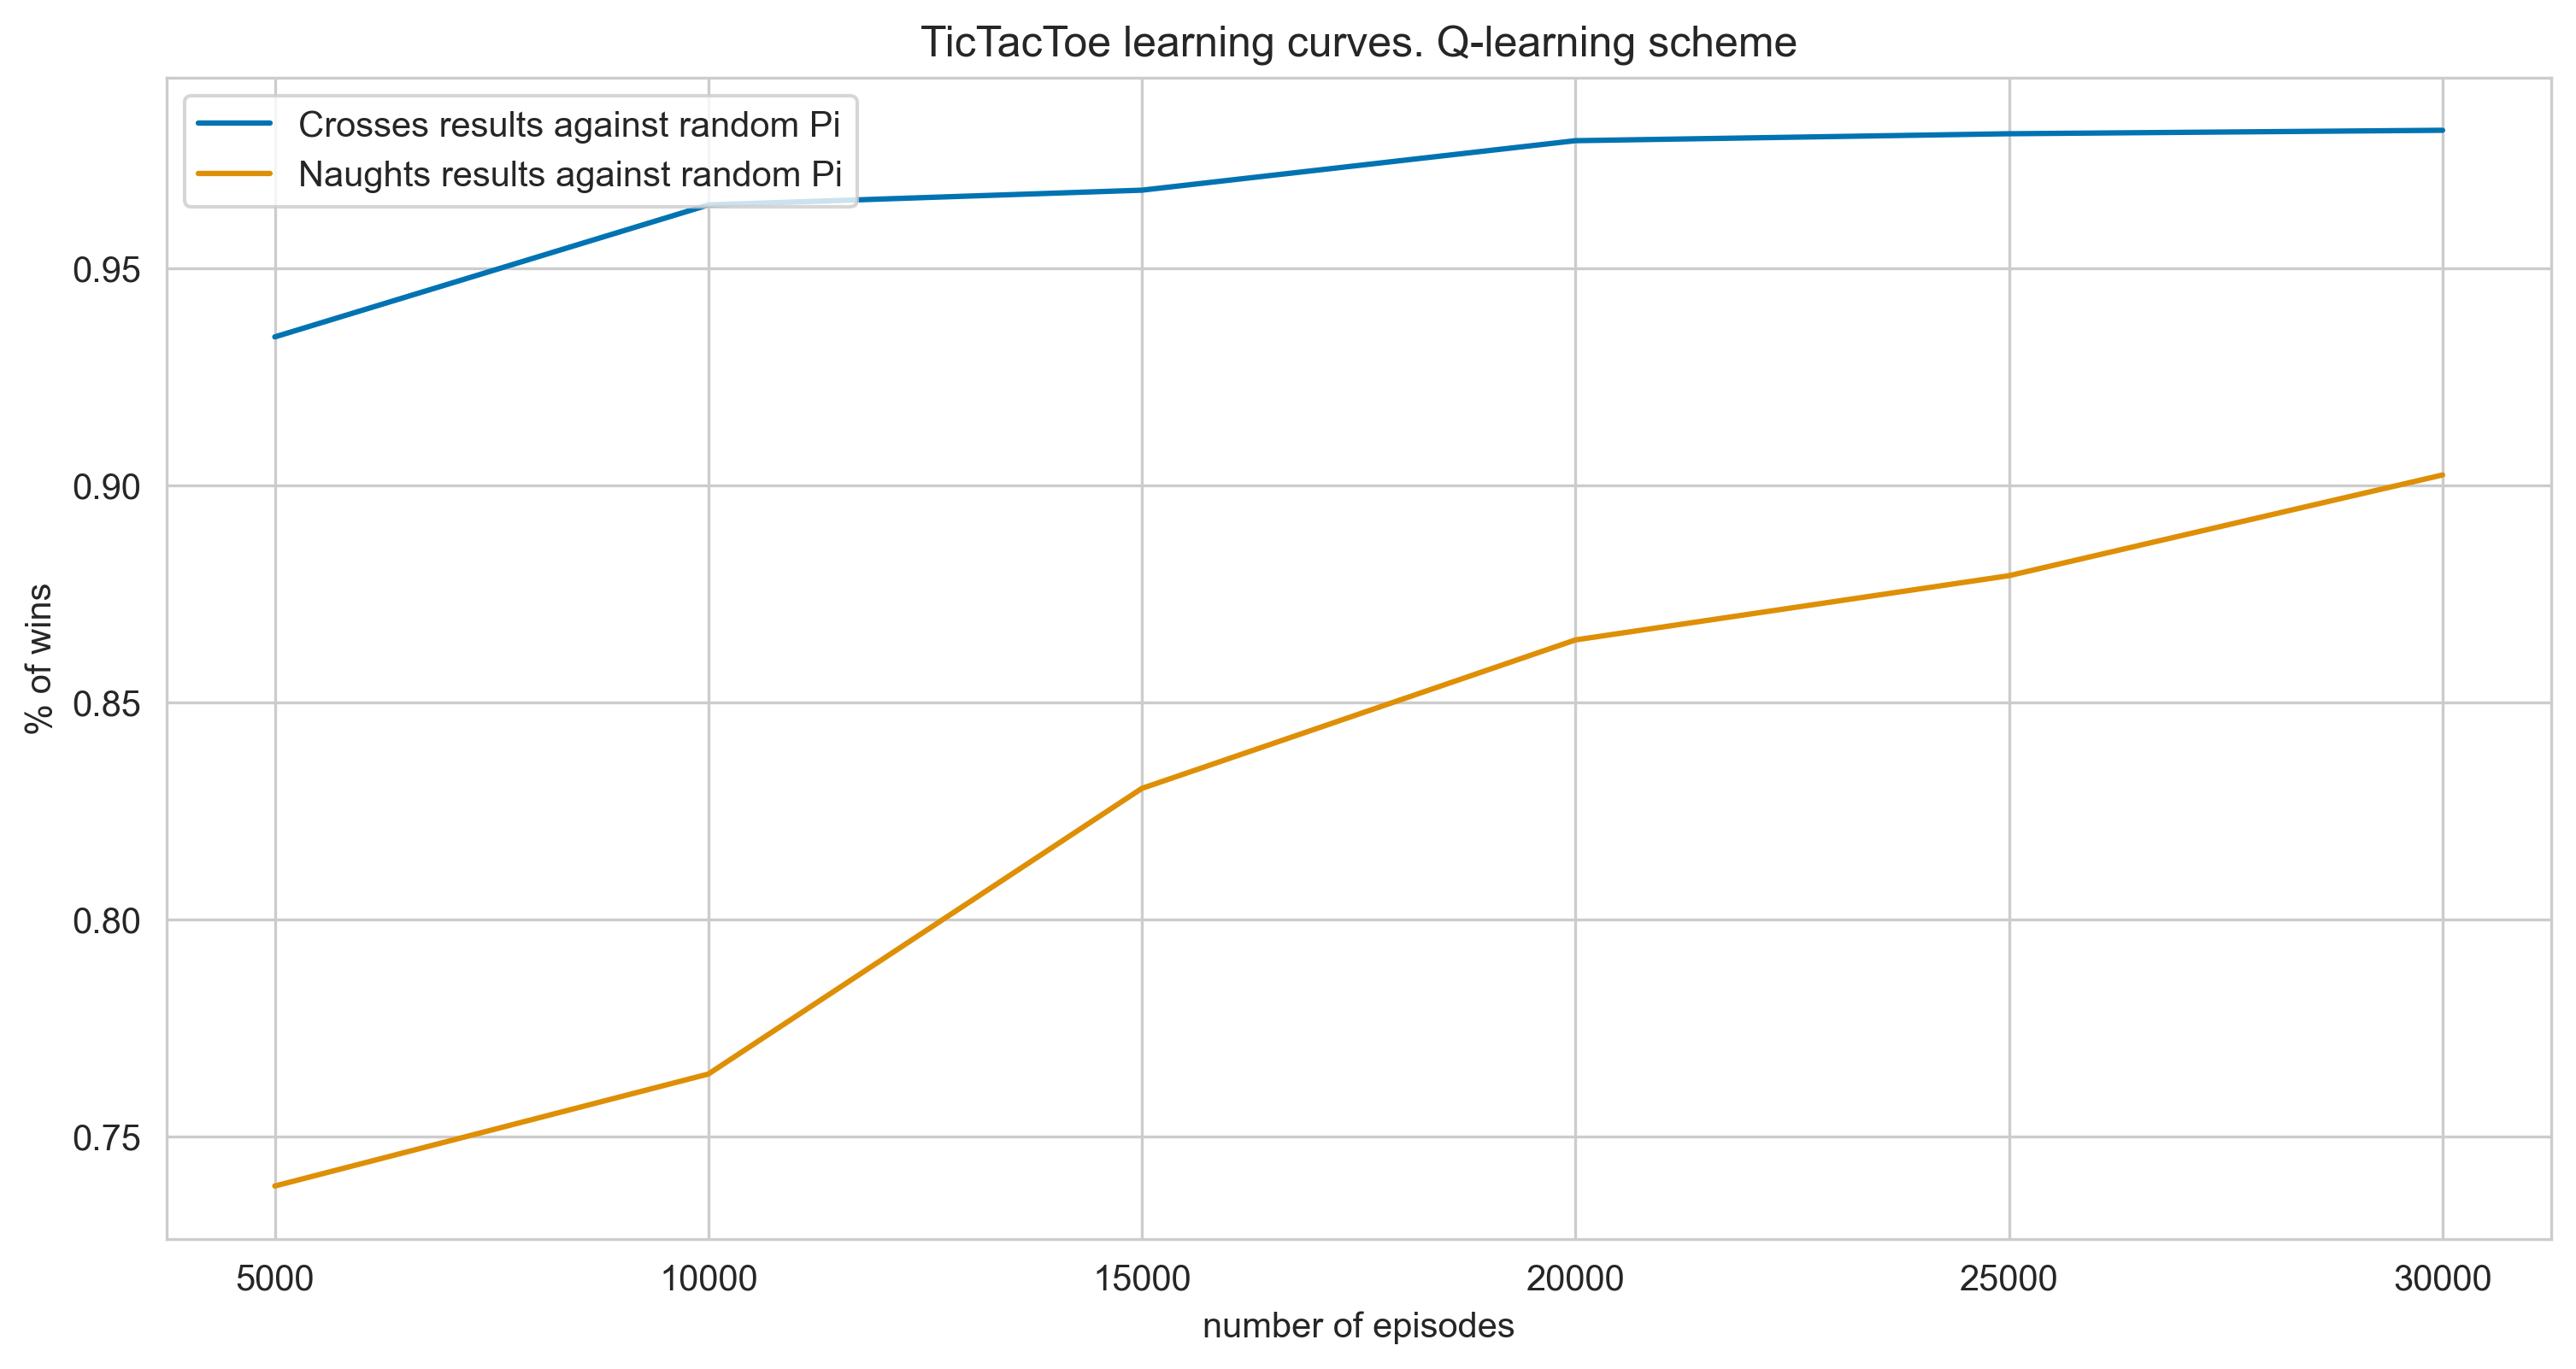

In [ ]:
plt.figure(figsize=(12, 6))
#plt.ylim(-1, 0.2)
xs = [5000 * i for i in range(1, 7)]
plt.plot(xs, crosses_results, label='Crosses results against random Pi')
plt.plot(xs, naughts_results, label='Naughts results against random Pi')
plt.title('TicTacToe learning curves. Q-learning scheme')
plt.xlabel('number of episodes')
plt.ylabel('% of wins')
plt.legend(loc='upper left')
plt.show()

### Часть 1. Вопрос 2
#### Во второй части задания реализуем только для доски 4х4 из-за слишком долгого обучения

In [9]:
env = TicTacToe(4, 4, 4)

In [10]:
# generate states space: all the states where -1 < (number of naughts - number of crosses) < 1

combinations = product('012', repeat=16)

valid_states = []
infinum = 1.0
supremum = 1.1

for s in combinations:
    criterium = sum([int(n) for n in s]) / 16
    if infinum <= criterium < supremum:
        valid_states.append(''.join(s))
        
states = {h: v for v, h in enumerate(valid_states)}

In [11]:
nS = len(valid_states)
nA = 16

In [12]:
nS

10165779

In [24]:
# Function mimicking reward obtained through playing against random policy

def episode_reward(pi, player=1):
    env.reset()
    done = False
    observation = [''.join(['1']*16)]

    while not done:
        empty_cells = env.getEmptySpaces().tolist()
        
        if env.curTurn == player:
            
            s = states[observation[0]]
            #next_action = action_space_dict[pi[s]]
            next_action = env.action_from_int(pi[s])
            
            if next_action in empty_cells:
                observation, reward, done, info = env.step(next_action)
            else:
                next_action = empty_cells[np.random.randint(len(empty_cells))]
                observation, reward, done, info = env.step(next_action)
        else:
            next_action = empty_cells[np.random.randint(len(empty_cells))]
            observation, reward, done, info = env.step(next_action)
    
    return reward

In [14]:
# Player class containing both policy and Q-function along with move() and update() methods
# Naughts and crosses are assumed to be of Player class

class Player():
    def __init__(self, name, pi, Q, epsilon=0.1, gamma=1., alpha=0.01):
        self.name = name
        self.pi = pi
        self.Q = Q
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.s = states[''.join(['1']*16)]
        self.a = None
        
    def move(self, env, start=None):
        if start is not None:
            self.a = np.random.randint(nA)
        else:
            state, vacant_cells, cur_turn = env.getState()
            self.s = states[state]
            actions = vacant_cells.tolist()
            
            if (action_space_dict[self.pi[self.s]] in actions) and (len(actions) > 1):
                actions.remove(action_space_dict[self.pi[self.s]])
                action = action_space_dict[self.pi[self.s]] if np.random.rand() > self.epsilon else sample(actions, 1)[0]
            else:
                action = sample(actions, 1)[0]

            self.a = env.int_from_action(action)
            
        observation, reward, done, _ = env.step(env.action_from_int(self.a))
        if done:
            self.Q[self.s, self.a] = reward
            
            if self.name == 'crosses':
                self.pi = np.argmax(self.Q, axis=1)
            else:
                self.pi = np.argmin(self.Q, axis=1)

        return observation, reward, done
        
    def update(self, env, reward):
        
        s = self.s
        a = self.a
        
        new_state, _, _ = env.getState()
        s_prime = states[new_state]

        if reward != 0:
            self.Q[s, a] = reward
        else:
            if self.name == 'crosses':
                self.Q[s][a] = self.Q[s][a] + self.alpha * (self.gamma * np.max(self.Q[s_prime]) - self.Q[s][a])
                self.pi = np.argmax(self.Q, axis=1)
            else:
                self.Q[s][a] = self.Q[s][a] + self.alpha * (self.gamma * np.min(self.Q[s_prime]) - self.Q[s][a])
                self.pi = np.argmin(self.Q, axis=1)
                
        self.s = s_prime

In [15]:
# Training loop

Q_c = np.zeros((nS, nA))
pi_c = np.argmax(Q_c, axis=1)
crosses = Player('crosses', pi_c, Q_c, epsilon=0.45, alpha=0.05)
crosses_policies = []

Q_n = np.zeros((nS, nA))
pi_n = np.argmax(Q_n, axis=1)
naughts = Player('naughts', pi_n, Q_n, epsilon=0.45, alpha=0.05)
naughts_policies = []

total_episodes = 1000

for i in tqdm(range(total_episodes)):
    env.reset()
    crosses.move(env, 1)
    done = False

    while not done:
        new_state, reward, done = naughts.move(env)
        crosses.update(env, reward)
        if done:
            break
            
        new_state, reward, done = crosses.move(env)
        naughts.update(env, reward)
        if done:
            break
            
    if (i > 0) and (i % 100 == 0):
        crosses_policies.append(crosses.pi)
        naughts_policies.append(naughts.pi)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
crosses_results = []
naughts_results = []


n = 5000

for policy in crosses_policies:
    res = 0
    
    for i in range(n):
        
        reward = episode_reward(policy, player=1)
        if reward == 1:
            res += 1

    crosses_results.append(res / n)
        
for policy in naughts_policies:
    res = 0
    
    for i in range(n):
        reward = episode_reward(policy, player=-1)
        if reward == -1:
            res += 1

    naughts_results.append(res / n)

In [27]:
crosses_results

[0.3178, 0.314, 0.3268, 0.3184, 0.3146, 0.3278, 0.31, 0.3132, 0.321]

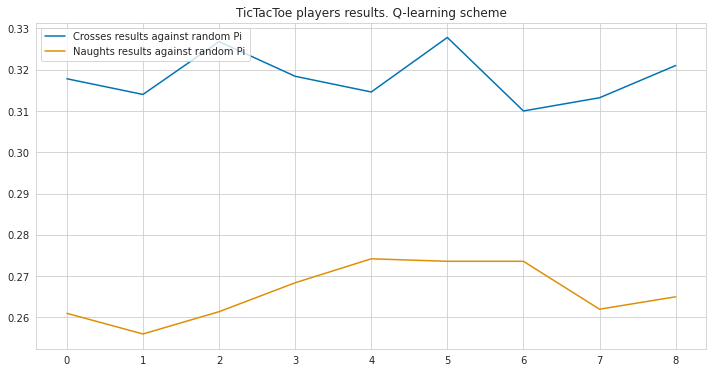

In [28]:
plt.figure(figsize=(12, 6))
#plt.ylim(-1, 0.2)
plt.plot(range(len(crosses_policies)), crosses_results, label='Crosses results against random Pi')
plt.plot(range(len(naughts_policies)), naughts_results, label='Naughts results against random Pi')
plt.title('TicTacToe players results. Q-learning scheme')
plt.legend(loc='upper left')
plt.show()

### Часть 2. Вопрос 1
#### А) Обучение политики крестиков. Базовый DQN

План действий: 
1. Для устойчивости обучения нормализовать данные, отобразив их из диапазона [0, 2] в [0, 1]. 
2. Для обучения ноликов из replay buffer выкинуть случайным образом 75% траекторий, закончившихся победой крестиков.
   Это делает обучение ноликов намного более стабильным.
3. Вместо сверточной модели воспользуемся MLP, так как на нем получлось достичь лучшего результата.

In [29]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from collections import deque
import random
import pickle
import copy
from tqdm.notebook import tqdm

In [42]:
GAMMA = 1.0
INITIAL_STEPS = 3000
TRANSITIONS = 30001
STEPS_PER_UPDATE = 1
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 128
LEARNING_RATE = 2e-4
EPS = 0.45

In [31]:
def flatten_state(state):
    map_state = {'0': 0.5, '1': 0., '2': 1.}
    return torch.tensor(np.array([map_state[i] for i in state]), dtype=torch.float)

In [32]:
class Qmodel(nn.Module):
    def __init__(self, action_size, seed=123):
        super(Qmodel, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.fc1 = nn.Linear(action_size, action_size * 4)
        self.fc2 = nn.Linear(action_size * 4, action_size * 4)
        self.fc3 = nn.Linear(action_size * 4, action_size * 2)
        self.fc4 = nn.Linear(action_size * 2, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [33]:
class DQN:
    def __init__(self, action_dim):
        self.steps = 0  
        self.action_space = action_dim
        self.buffer = deque(maxlen=10000)
        self.q_model = Qmodel(self.action_space).to(device) # Qmodel
        self.q_target = Qmodel(self.action_space).to(device) # Qmodel
        self.optimizer = Adam(self.q_model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.MSELoss()

    def consume_transition(self, transition):
        # Add transition to a replay buffer. Using dequee
        self.buffer.append(transition)

    def sample_batch(self):
        # Sample batch from a replay buffer.
        batch = random.sample(self.buffer, BATCH_SIZE)

        state, action, next_state, reward, done = list(zip(*batch))
        state = torch.stack(state)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.stack(next_state)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.float32))

        batch = (state, action, next_state, reward, done)

        return batch

    def train_step(self, batch):
        # Use batch to update DQN's network.
        states, actions, next_states, rewards, dones = batch
        q_target = self.q_target(next_states).detach().max(1)[0]
        expected_rewards = rewards + GAMMA * q_target * (1 - dones)
        output = self.q_model(states).gather(1, actions[:, None]).squeeze()
        loss = F.mse_loss(output, expected_rewards)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return

    def update_target_network(self):
        # Update weights of a target Q-network here. 
        # assign a values of network parameters via PyTorch methods.
        for target_param, model_param in zip(self.q_target.parameters(), self.q_model.parameters()):
            target_param.data.copy_(model_param.data)

    def act(self, state):
        # Compute an action.
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)

        self.q_model.eval()
        with torch.no_grad():
            action_values = self.q_model(state)
        self.q_model.train()

        return np.argmax(action_values.cpu().data.numpy())

    def update(self, transition):
        self.consume_transition(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
        self.steps += 1

In [34]:
def dqn_edpisode(pi, player=1, dim=9):
    env.reset()
    done = False
    observation = [''.join(['1'] * dim)]

    while not done:
        empty_cells = env.getEmptySpaces()
        
        if env.curTurn == player:
            
            s = flatten_state(observation[0])
            next_action = env.action_from_int(pi.act(s))
            
            observation, reward, done, info = env.step(next_action)
            
        else:
            next_action = empty_cells[np.random.randint(len(empty_cells))]
            observation, reward, done, info = env.step(next_action)
    
    return reward


def evaluate_policy(policy, player=1, n=1000, dim=9):
    res = 0

    for _ in range(n):
        reward = dqn_edpisode(policy, player=player, dim=dim)
        
        if reward == player:
            res += 1

    return res / n

In [43]:
env = TicTacToe(3, 3, 3)
action_space = [[i, j] for i in range(3) for j in range(3)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nA = 9
dqn = DQN(action_dim=nA)
#eps = 0.4

crosses_learning_curve = []

for _ in tqdm(range(INITIAL_STEPS)):
    env.reset()
    done = False
    
    while not done:
        state = flatten_state(env.getState()[0]) 
        action = random.sample(env.getEmptySpaces().tolist(), 1)[0] #sample(action_space, 1)[0]
        observation, reward, done, _ = env.step(action)
        if done:
            next_state = flatten_state(observation[0])
        else:
            opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0]   ### REPLACE WITH SMART POLICY
            observation, reward, done, _ = env.step(opponent_action)
            next_state = flatten_state(observation[0])
            
        num_action = env.int_from_action(action)
        dqn.consume_transition((state, num_action, next_state, reward, done))
        

for i in tqdm(range(TRANSITIONS)):
    env.reset()
    done = False
    
    while not done:
        state = flatten_state(env.getState()[0])
        
        if random.random() < EPS:
            action = random.sample(env.getEmptySpaces().tolist(), 1)[0]
        else:
            num_action = dqn.act(state)
            action = env.action_from_int(num_action)
        
        observation, reward, done, _ = env.step(action)
        
        if done:
            next_state = flatten_state(observation[0])
        else:
            opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0] 
            observation, reward, done, _ = env.step(opponent_action)
            next_state = flatten_state(observation[0])
            
        num_action = env.int_from_action(action)
        dqn.update((state, num_action, next_state, reward, done))
        
    if (i > 0) and (i % 5000 == 0):
        res = evaluate_policy(dqn)
        print(res)
        crosses_learning_curve.append(res)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/30001 [00:00<?, ?it/s]

0.832
0.877
0.888
0.902
0.881
0.921


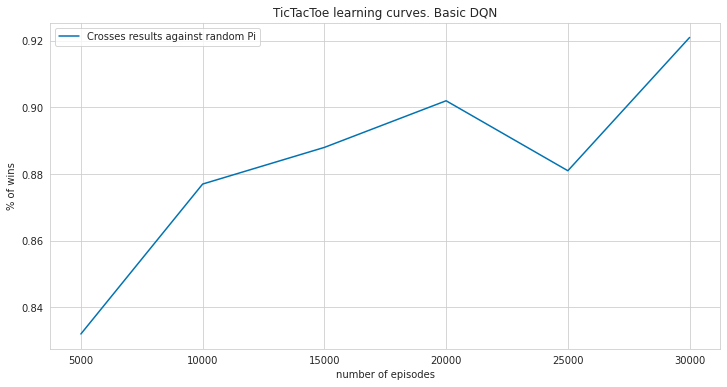

In [44]:
plt.figure(figsize=(12, 6))
xs = [5000 * i for i in range(1, 7)]
plt.plot(xs, crosses_learning_curve, label='Crosses results against random Pi')
plt.title('TicTacToe learning curves. Basic DQN')
plt.xlabel('number of episodes')
plt.ylabel('% of wins')
plt.legend(loc='upper left')
plt.show()

#### Б) Обучение политики ноликов. Базовый DQN

In [37]:
GAMMA = 1.0
INITIAL_STEPS = 5500
TRANSITIONS = 30001
STEPS_PER_UPDATE = 1
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPS = 0.45

In [38]:
env = TicTacToe(3, 3, 3)
action_space = [[i, j] for i in range(3) for j in range(3)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
map_reward = {0: 0, -1: 1, 1: -1, -10: -10}
nA = 9
dqn = DQN(action_dim=nA)
eps = 0.4

naughts_learning_curve = []

for i in tqdm(range(INITIAL_STEPS)):
    env.reset()
    done = False
    
    cnt = 0
    
    opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0]
    observation, reward, done, _ = env.step(opponent_action)
    
    while not done:
        cnt += 1
        state = flatten_state(env.getState()[0]) 
        action = random.sample(env.getEmptySpaces().tolist(), 1)[0]
        observation, reward, done, _ = env.step(action)
        if done:
            next_state = flatten_state(observation[0])
        else:
            opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0]   ### REPLACE WITH SMART POLICY
            observation, reward, done, _ = env.step(opponent_action)
            next_state = flatten_state(observation[0])
            
        num_action = env.int_from_action(action)
        dqn.consume_transition((state, num_action, next_state, map_reward[reward], done))
        
    if (reward == 1) and (random.random() < 0.75):
        for i in range(cnt):
            dqn.buffer.pop()
        

for i in tqdm(range(TRANSITIONS)):
    env.reset()
    done = False
    
    opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0]
    observation, reward, done, _ = env.step(opponent_action)
    
    while not done:
        state = flatten_state(env.getState()[0])
        
        if random.random() < EPS:
            action = random.sample(env.getEmptySpaces().tolist(), 1)[0]
        else:
            num_action = dqn.act(state)
            action = env.action_from_int(num_action)
        
        observation, reward, done, _ = env.step(action)
        
        if done:
            next_state = flatten_state(observation[0])
        else:
            opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0] ### REPLACE WITH SMART POLICY
            observation, reward, done, _ = env.step(opponent_action)
            next_state = flatten_state(observation[0])
            
        num_action = env.int_from_action(action)
        dqn.update((state, num_action, next_state, map_reward[reward], done))
        
    if (i > 0) and (i % 5000 == 0):
        res = evaluate_policy(dqn, player=-1)
        print(res)
        naughts_learning_curve.append(res)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/30001 [00:00<?, ?it/s]

0.471
0.526
0.594
0.616
0.659
0.704


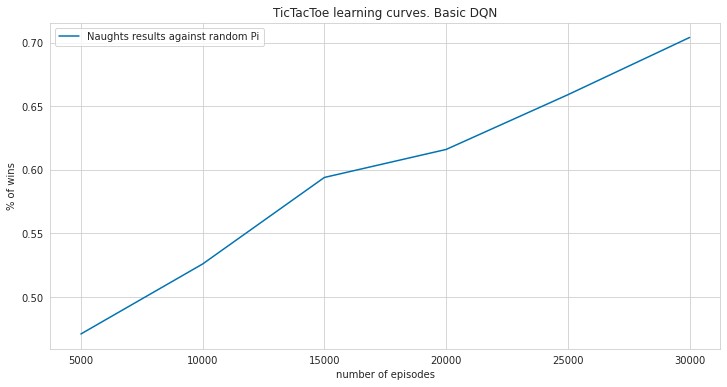

In [39]:
plt.figure(figsize=(12, 6))
xs = [5000 * i for i in range(1, 7)]
plt.plot(xs, naughts_learning_curve, label='Naughts results against random Pi')
plt.title('TicTacToe learning curves. Basic DQN')
plt.xlabel('number of episodes')
plt.ylabel('% of wins')
plt.legend(loc='upper left')
plt.show()

### Часть 2. Вопрос 2
#### Double DQN

В данном подходе меняется только формула получения ожидаемой оценки в классе DQN. Обучим на примере крестиков.

In [48]:
GAMMA = 1.0
INITIAL_STEPS = 3000
TRANSITIONS = 30001
STEPS_PER_UPDATE = 1
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 128
LEARNING_RATE = 2e-4
EPS = 0.45

In [49]:
class DQN:
    def __init__(self, action_dim):
        self.steps = 0  
        self.action_space = action_dim
        self.buffer = deque(maxlen=10000)
        self.q_model = Qmodel(self.action_space).to(device)
        self.q_target = Qmodel(self.action_space).to(device)
        self.optimizer = Adam(self.q_model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.BCELoss()

    def consume_transition(self, transition):
        # Add transition to a replay buffer. Using dequee
        self.buffer.append(transition)

    def sample_batch(self):
        # Sample batch from a replay buffer.
        batch = random.sample(self.buffer, BATCH_SIZE)

        state, action, next_state, reward, done = list(zip(*batch))
        state = torch.stack(state)
        action = torch.tensor(np.array(action, dtype=np.int64))
        next_state = torch.stack(next_state)
        reward = torch.tensor(np.array(reward, dtype=np.float32))
        done = torch.tensor(np.array(done, dtype=np.float32))

        batch = (state, action, next_state, reward, done)

        return batch

    def train_step(self, batch):
        # Use batch to update DQN's network.
        states, actions, next_states, rewards, dones = batch
#####################################################################################################
######################################## THIS PART CHANGED ##########################################
        next_state_actions = self.q_model(next_states).max(1)[1].unsqueeze(-1)
        q_target = self.q_target(next_states).gather(1, next_state_actions).squeeze(-1)
#####################################################################################################
#####################################################################################################        
        expected_rewards = rewards + GAMMA * q_target.detach() * (1 - dones)            
        output = self.q_model(states).gather(1, actions[:, None]).squeeze()    
        loss = F.mse_loss(output, expected_rewards)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return

    def update_target_network(self):
        # Update weights of a target Q-network here. 
        # assign a values of network parameters via PyTorch methods.
        for target_param, model_param in zip(self.q_target.parameters(), self.q_model.parameters()):
            target_param.data.copy_(model_param.data)

    def act(self, state):
        # Compute an action.
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)

        self.q_model.eval()
        with torch.no_grad():
            action_values = self.q_model(state)
        self.q_model.train()

        return np.argmax(action_values.cpu().data.numpy())

    def update(self, transition):
        self.consume_transition(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
        self.steps += 1

In [50]:
env = TicTacToe(3, 3, 3)
action_space = [[i, j] for i in range(3) for j in range(3)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nA = 9
dqn = DQN(action_dim=nA)
#eps = 0.4

crosses_learning_curve = []

for _ in tqdm(range(INITIAL_STEPS)):
    env.reset()
    done = False
    
    while not done:
        state = flatten_state(env.getState()[0]) 
        action = random.sample(env.getEmptySpaces().tolist(), 1)[0] #sample(action_space, 1)[0]
        observation, reward, done, _ = env.step(action)
        if done:
            next_state = flatten_state(observation[0])
        else:
            opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0]   ### REPLACE WITH SMART POLICY
            observation, reward, done, _ = env.step(opponent_action)
            next_state = flatten_state(observation[0])
            
        num_action = env.int_from_action(action)
        dqn.consume_transition((state, num_action, next_state, reward, done))
        

for i in tqdm(range(TRANSITIONS)):
    env.reset()
    done = False
    
    while not done:
        state = flatten_state(env.getState()[0])
        
        if random.random() < EPS:
            action = random.sample(env.getEmptySpaces().tolist(), 1)[0]
        else:
            num_action = dqn.act(state)
            action = env.action_from_int(num_action)
        
        observation, reward, done, _ = env.step(action)
        
        if done:
            next_state = flatten_state(observation[0])
        else:
            opponent_action = random.sample(env.getEmptySpaces().tolist(), 1)[0] ### REPLACE WITH SMART POLICY
            observation, reward, done, _ = env.step(opponent_action)
            next_state = flatten_state(observation[0])
            
        num_action = env.int_from_action(action)
        dqn.update((state, num_action, next_state, reward, done))
        
    if (i > 0) and (i % 2000 == 0):
        res = evaluate_policy(dqn)
        print(res)
        crosses_learning_curve.append(res)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/30001 [00:00<?, ?it/s]

0.795
0.848
0.874
0.886
0.893
0.886
0.898
0.901
0.902
0.883
0.873
0.898
0.946
0.891
0.895


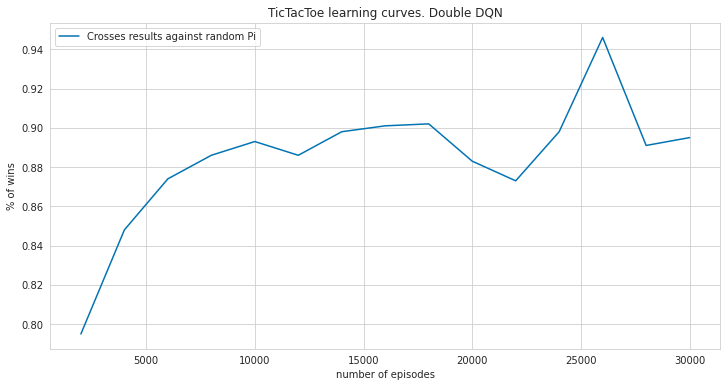

In [52]:
plt.figure(figsize=(12, 6))
xs = [2000 * i for i in range(1, 16)]
plt.plot(xs, crosses_learning_curve, label='Crosses results against random Pi')
plt.title('TicTacToe learning curves. Double DQN')
plt.xlabel('number of episodes')
plt.ylabel('% of wins')
plt.legend(loc='upper left')
plt.show()

### Часть 3. Вопрос 1
#### Rollouts

Роллауты реализуем просто в виде функции с дополнительной функцией преобразования строкового состояния в соответствующий environment с возможностью произвести роллаут из этого состояния следующим образом:

In [8]:
def rollout(env, pi_crosses='random', pi_naughts='random'):
    reward = env.isTerminal()
    if reward is not None:
        return reward
    
    done = False
    
    #cnt = 0
    
    while not done:
        #cnt += 1
        #print(cnt)
        state, empty_cells, done = env.getState()
        turn = env.curTurn
        
        if turn == 1:
            if pi_crosses == 'random':
                next_action = empty_cells[np.random.randint(len(empty_cells))]
            else:
                s = states[state]
                next_action = action_space_dict[pi_crosses[s]]
        else:
            if pi_naughts == 'random':
                next_action = empty_cells[np.random.randint(len(empty_cells))]
            else:
                s = states[state]
                next_action = action_space_dict[pi_naughts[s]]
                
        observation, reward, done, info = env.step(next_action)
        
    return reward

In [9]:
def state_to_env(state):
    balance = sum([int(i) for i in state]) / len(state)
    turn = -1 if balance > 1.0 else 1
    
    board = np.array([(int(i) - 1) for i in state]).reshape((N_ROWS, N_COLS))
    
    env = TicTacToe(N_ROWS, N_COLS, N_WIN)
    env.board = board
    env.curTurn = turn
    
    return env

In [10]:
# Rollout demo:
env = state_to_env('112020111')
rollout(env)

1

### Часть 3. Вопрос 2
#### MCTS

Здесь приходится признать, что Monte-Carlo Tree Search получился плохо. Он выдает довольно низкий результат. Сначала был реализован exhaustive search с запуском роллаутов из каждого состояния. Что касается UCB, то при применении UCB выбора значения value-function оказывались очень близкими друг к другу.

Тем не менее, план действий:
- завести класс Tree, отображающий структуру дерева поиска
- создать полное дерево ходов, производя роллауты на каждом уровне дерева и обновляя значения value-function состояний.
- обучить дерево максимизацией UCB

Примечание: при реализации схемы rollouts каждое состояние, из которого производятся rollouts, отображает мат ожидание выигрыша по всем более глубоким состояниям, т.е. value-function.

In [11]:
class Tree:
    def __init__(self, state, action=None):
        self.state = state
        self.value = 0
        self.children = {}
        self.parent = None
        self.visited = 0
        self.action = action
        self.level = 0
        self.ucb = 0
        self.iter = 1
        
    def add(self, child):
        self.children[child.state] = child
        child.parent = self
        child.level = self.level + 1
        return
    
    def backprop(self, reward):
        node = self
        while node is not None:
            node.value = (node.value * node.visited + reward) / (node.visited + 1)
            node.visited += 1
            self.iter = self.parent.iter
            node.ucb = node.value + np.sqrt(2) * np.sqrt(np.log(self.iter) / self.visited)
            node = node.parent
            

In [12]:
# Function returning dict of next states and corresponding actions leading to those states

def next_states(state):
    
    action_states = {}
    child_states = []
    balance = sum([int(i) for i in state]) / len(state)
    turn = 0 if balance > 1.0 else 1
    empty_cells = [[int(i) // N_ROWS, int(i) % N_COLS] for i, elem in enumerate(state) if elem == '1']
        
    for coord in empty_cells:
        sub_string = (state[:coord[0] * N_ROWS + coord[1]], state[coord[0] * N_ROWS + coord[1] + 1:])
        if turn == 1:
            child_state = sub_string[0] + str('2') + sub_string[1]
        else:
            child_state = sub_string[0] + str('0') + sub_string[1]
            
        action_states[child_state] = coord

        child_states.append(child_state)
        
    return action_states

In [13]:
def episode_reward(player=1):
    env.reset()
    done = False
    observation = [''.join(['1']*16)]
    node = root

    while not done:
        empty_cells = env.getEmptySpaces().tolist()

        if env.curTurn == player:

            state, _, _ = env.getState()
            next_state_idx = np.argmax(np.array([n[1].value for n in node.children.items()]))
            next_state = np.array([n[1] for n in node.children.items()])[next_state_idx]
            next_action = next_state.action

            observation, reward, done, info = env.step(next_action)
            node = node.children[observation[0]]

        else:
            next_action = empty_cells[np.random.randint(len(empty_cells))]
            observation, reward, done, info = env.step(next_action)
            node = node.children[observation[0]]

    return reward

In [21]:
# Exhaustive search for 3 by 3 TicTacToe via breadth-first search over a states tree for crosses (player = +1):

tree_depth = 8 
num_rollouts = 5
player = 1
q = deque()

env = TicTacToe(3, 3, 3)
env.reset()
state, empty_cells, turn = env.getState()
root = Tree(state)
q.append(root)

    
while q:

    v = q.popleft()
    allowed_states = next_states(v.state)

    for state in allowed_states.items():
        new_node = Tree(state[0], state[1])
        v.add(new_node)
        q.append(new_node)

        if new_node.level > tree_depth:
            q.clear()
            break

        if new_node.level == tree_depth:
            env = state_to_env(new_node.state)
            reward = 0
            for _ in range(num_rollouts):
                if rollout(env) == player:
                    reward += 1
            new_node.backprop(reward / num_rollouts)

Выведем результат 5000 игр для крестиков. 

In [22]:
res = 0
n = 5000
player = 1
    
for i in range(n):
    reward = episode_reward(player=player)
    if reward == player:
        res += 1

print(res / n)

0.9622


Попробуем теперь обучить дерево при помощи выбора пути через максимизацию UCB. Для этого сначала построим полное дерево ходов, а затем
будем выбирать пути с максимумом UCB, предварительно подергав за все ручки.

In [23]:
# Build new tree to get structure of states without learning:

tree_depth = 9 
num_rollouts = 5
player = 1
q = deque()

env = TicTacToe(3, 3, 3)
env.reset()
state, empty_cells, turn = env.getState()
root = Tree(state)
q.append(root)

    
while q:

    v = q.popleft()
    allowed_states = next_states(v.state)

    for state in allowed_states.items():
        new_node = Tree(state[0], state[1])
        v.add(new_node)
        q.append(new_node)

        if new_node.level > tree_depth:
            q.clear()
            break

In [24]:
# Train the tree via maximazing UCB:

q.append(root)
repetitions = 100
tree_depth = 8
visited = set()


while q:
    node = q.popleft()
    if node.level == tree_depth - 1:
        q.clear()
        break
        
    children = [n[1] for n in node.children.items()]
    node.iter = repetitions
    
    for child in children:
        env = state_to_env(child.state)

        if rollout(env) == player:
            reward = 1
        child.backprop(reward / num_rollouts)
        

    for it in range(repetitions):
        ucbs = np.array([node.ucb for node in children])
        child = children[np.argmax(ucbs)]

        env = state_to_env(child.state)

        if rollout(env) == player:
            reward = 1
        child.backprop(reward / num_rollouts)
        
    for child in children:
        
        if child.state not in visited:
            visited.add(child.state) 
            q.append(child)

In [25]:
res = 0
n = 5000
player = 1
    
for i in range(n):
    reward = episode_reward(player=player)
    if reward == player:
        res += 1

print(res / n)

0.669
